### Etape 2 - Préparer les données, former et évaluer les modèles M

In [31]:
#Importing data
import pandas as pd
data = pd.read_pickle("data/trees_clean.p")
data.head(5)


,SOUS_CATEGORIE,CODE_PARENT,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,ANNEEDEPLANTATION,COLLECTIVITE,LONGITUDE,LATITUDE
13,ESP151,ESP36926,1,NaN,NaN,NaN,2017.0,Grenoble Alpes Métropole,5.709930,45.201111
14,ESP151,ESP36926,1,NaN,NaN,NaN,2017.0,Grenoble Alpes Métropole,5.709895,45.201185
15,ESP151,ESP36926,1,NaN,NaN,NaN,2017.0,Grenoble Alpes Métropole,5.709864,45.201254
16,ESP151,ESP36926,1,NaN,NaN,NaN,2017.0,Grenoble Alpes Métropole,5.709828,45.201321
17,ESP151,ESP36926,1,Platanus,NaN,NaN,2017.0,Grenoble Alpes Métropole,5.709681,45.201682


In [32]:
#train test splitting and defining Categorical vs numric
from sklearn.model_selection import train_test_split
target = 'ANNEEDEPLANTATION'
num_col = ['LONGITUDE',	'LATITUDE'] #only features, not the target
cat_col = list(set(data.columns).difference([target]).difference(num_col)) 
y = data[target]
X = data[num_col+cat_col]
X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.20, random_state=42)

In [33]:
#preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#numeric pipeline
num_pipe = Pipeline([
    ('SimpleImputer_num', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
#categoric pipeline
cat_pipe = Pipeline([
    # ('SimpleImputer_cat', SimpleImputer(strategy='most_frequent')), #most frequent / const (to be defined)
    ('SimpleImputer_cat', SimpleImputer(strategy='constant',fill_value=None)), #most frequent / const (to be defined)
    ('One Hot Encoder', OneHotEncoder(handle_unknown='infrequent_if_exist'))])
#merging pipeline
pipe = ColumnTransformer([
    ('num',num_pipe,num_col),
    ('cat',cat_pipe,cat_col)])

In [34]:
#transforming using the preprocessing pipe
X_train_pipe = pipe.fit_transform(X_train)
X_test_pipe = pipe.transform(X_test)
#model fitting
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()
linReg.fit(X_train_pipe,y_train)

LinearRegression()

In [35]:
# Model prediction And Metrics
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import root_mean_squared_error
import numpy as np 
y_pred_train = linReg.predict(X_train_pipe)
y_pred_test = linReg.predict(X_test_pipe)
result = pd.DataFrame()
result.loc['train','MSE'] = mean_squared_error(y_pred_train,y_train)
result.loc['test','MSE'] = mean_squared_error(y_pred_test,y_test)
result.loc['train','RMSE'] = np.sqrt(result.loc['train','MSE'])
result.loc['test','RMSE'] = np.sqrt(result.loc['test','MSE'])
result



,MSE,RMSE
train,32.701126,5.718490
test,39.937969,6.319649


In [36]:
import numpy as np
import matplotlib.pyplot as plt

def plot_norm_hist(data, vline = True, title= True,ax = plt):
    mu, sigma = np.mean(data), np.std(data)
    # count, bins, ignored = plt.hist(data, 30)
    count, bins, ignored = plt.hist(data, 30, density=True)
    ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
            np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
        linewidth=2, color='r')
    
    if vline:
        lline = -.67*sigma + mu
        uline = .67*sigma + mu
        ax.axvline(lline, color='g')
        ax.axvline(uline, color='g')

    if title:
        if ax == plt:
            ax.title("Normal distribution with mean: {:.02f} and StDev: {:.02f}".format(mu, sigma))
        else:
            ax.set_title("Normal distribution with mean: {:.02f} and StDev: {:.02f}".format(mu, sigma))
def standard(data):
    return((data - np.mean(data))/np.std(data))

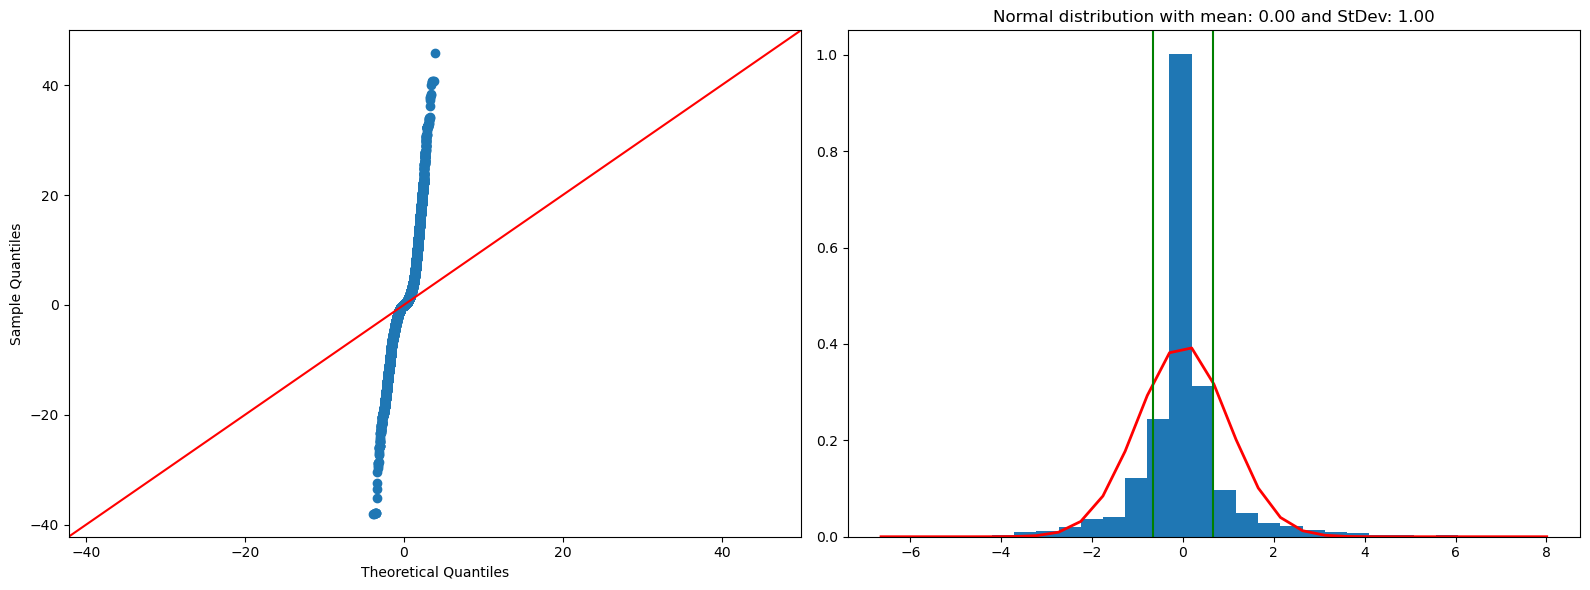

In [37]:
#residuals plot for ml predictions  
import statsmodels.api as sm ## QQplot
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats ## Bell curve
residual_train = y_train - y_pred_train
residual_test = y_train - y_pred_train
np.std(residual_train)
np.mean(residual_train) 

plt.figure(figsize=(16,6))
axes = [plt.subplot(1,2,1),plt.subplot(1,2,2)]
#create Q-Q plot with 45-degree line added to plot
sm.qqplot(residual_train, line='45',ax=axes[0])
plot_norm_hist(standard(residual_test),ax = axes[1])
plt.tight_layout()

In [56]:
from sklearn.model_selection import cross_validate
linReg = LinearRegression()
cross_validate(estimator=linReg,X=X_train_pipe,y=y_train,cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')

{'fit_time': array([0.75353336, 0.67501116, 0.6638236 , 0.676337  , 0.75431991]),
 'score_time': array([0.00081348, 0.00104856, 0.00109124, 0.00096035, 0.00131989]),
 'test_score': array([-6.360753  , -6.36615737, -6.12064742, -6.21531683, -6.43405029])}

In [85]:
#input X_train_pipe,y_train, X_test_pipe, y_test
#INITIALIZE MODEL TO USE
def init_model_dict(model_gen):
    model_dict = {
    "model_gen":model_gen,
    "params":None,
    "pickle_file":None,
    "RMSE_CV":None,#[[RMSE_i],mean RMSE, std RMSE]
    "RMSE_test":None}
    return(model_dict)
import os.path
import time #exec time display
import joblib
#FIT AND STORE
def fitAndStoreModels(regr_model:dict,X_train,y_train, reset=False):
    for model_name in regr_model.keys():
        if regr_model[model_name]['pickle_file'] == None:
            file_name = f"{model_name}.pkl"
            if (not os.path.isfile(file_name)) or reset:
                print(f"Creating and fitting model {model_name}")
                start_time = time.time()
                model = regr_model[model_name]['model_gen']()
                model.fit(X_train,y_train)
                print(f"done in {time.time() - start_time} s")
                joblib.dump(model, file_name)
                print(f"Storing model {model_name} in {file_name}\nto use it :\nmodel = joblib.load({file_name})")
            else:
                print(f"The model {model_name} has been already fit :\n set reset=True to refit the model")
            regr_model[model_name]['pickle_file'] = file_name
    return None
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_validate
def compute_CV(regr_model:dict,X_train,y_train, n_fold:int, reset = False):
    for model_name in regr_model.keys():
        if regr_model[model_name]['RMSE_CV'] == None or reset_result:
            print(f"Computing Cross_validation on model {model_name} with {n_fold} folds")
            model = regr_model[model_name]['model_gen']()
            regr_model[model_name]['RMSE_CV'] = cross_validate(estimator=model,X=X_train,y=y_train,cv=n_fold,n_jobs=-1,scoring='neg_root_mean_squared_error')
            print(f"CV Done:{regr_model[model_name]['RMSE_CV']}")
    return None
#RMSE
def compute_RMSE(regr_model:dict,X_test,y_test,reset = False):
    for model_name in regr_model.keys():
        if regr_model[model_name]['pickle_file'] != None and (regr_model[model_name]['RMSE_test'] == None or reset):
            print(f"Loading and predictions on model {model_name}")
            start_time = time.time()
            model = joblib.load(regr_model[model_name]['pickle_file'])
            y_pred_test = model.predict(X_test)
            print(f"done in {time.time() - start_time} s")
            regr_model[model_name]['RMSE_test'] = root_mean_squared_error(y_pred_test,y_test)
            print(f"RMSE {model_name} (test): {regr_model[model_name]['RMSE_test']}")
    return None
import pandas as pd 
#DISPLAY
def display_result(regr_model:dict):
    df = pd.DataFrame(columns=list(regr_model.keys()))
    for model_name in regr_model.keys():
        df.loc['RMSE_test',model_name] = regr_model[model_name]['RMSE_test']
        df.loc['CV mean NRMSE',model_name] = np.mean(regr_model[model_name]['RMSE_CV']['test_score'])
        df.loc['CV std NRMSE',model_name] = np.std(regr_model[model_name]['RMSE_CV']['test_score'])
    display(df)
    return None
            

In [86]:
### RESETS THE MODELS
#Testing and compairing different ml-models for regression
from sklearn.svm import SVR #Support Vector Machine
from sklearn.ensemble import GradientBoostingRegressor #Gradient Boosting Regression
from sklearn.linear_model import LinearRegression #Linear Regression
regr_model = {}
inputs = [('LinRegr',LinearRegression),('GBR',GradientBoostingRegressor)]
# inputs = [('LinRegr',LinearRegression),('SVR',SVR),('GBR',GradientBoostingRegressor)]
for (name,model_gen) in inputs:
    regr_model[name]=init_model_dict(model_gen)
    print(f"Initialize model {name}")

Initialize model LinRegr
Initialize model GBR


In [ ]:
fitAndStoreModels(regr_model,X_train_pipe,y_train)
compute_CV(regr_model,X_train=X_train_pipe,y_train=y_train,n_fold=5)
compute_RMSE(regr_model,X_test_pipe, y_test)
display_result(regr_model)

Creating and fitting model LinRegr
done in 0.4409451484680176 s
Storing model LinRegr in LinRegr.pkl
to use it :
model = joblib.load(LinRegr.pkl)
Creating and fitting model GBR
done in 3.227739095687866 s
Storing model GBR in GBR.pkl
to use it :
model = joblib.load(GBR.pkl)
Computing Cross_validation on model LinRegr with 5 folds
CV Done:{'fit_time': array([0.57350683, 0.64003873, 0.62717867, 0.71553874, 0.70010567]), 'score_time': array([0.00128508, 0.00084591, 0.00091219, 0.00124788, 0.00076103]), 'test_score': array([-6.360753  , -6.36615737, -6.12064742, -6.21531683, -6.43405029])}
Computing Cross_validation on model GBR with 5 folds
CV Done:{'fit_time': array([3.41750622, 3.07584834, 3.91816926, 3.95593905, 3.30356598]), 'score_time': array([0.00875545, 0.00904179, 0.01156354, 0.01057458, 0.00888491]), 'test_score': array([-9.5166008 , -9.40941396, -9.53837091, -9.29823534, -9.79784395])}
Loading and predictions on model LinRegr
done in 0.0007696151733398438 s
RMSE LinRegr (test):

,LinRegr,GBR
RMSE_test,6.319649,9.472873
CV mean NRMSE,-9.512093,-9.512093
CV std NRMSE,0.166519,0.166519


In [75]:
regr_model['LinRegr']['RMSE_CV']['test_score']
regr_model['GBR']['RMSE_CV']['test_score']

array([-9.51635446, -9.40985012, -9.53723466, -9.29786092, -9.79961891])